In [1]:
import modules.board_module as bf
import modules.tree_module as tf
import modules.stockfish_module as sf
from ModelSaver import ModelSaver
import random
from dataclasses import dataclass
from collections import namedtuple
import itertools
import time
import argparse
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datetime import datetime
from math import floor, ceil
import pandas as pd

from train_nn_evaluator import Trainer, EvalDataset, ChessNet, ResNet
from assemble_data import Move, Position

In [2]:
# load in the entire dataset
num_rand = 4096
datapath = "/home/luke/chess/python/gamedata/samples"
eval_file_template = "random_n={0}_sample"
inds = list(range(1))
log_level = 1
dataset = EvalDataset(datapath, eval_file_template.format(num_rand),
                      indexes=inds, log_level=log_level)

Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_354.lz4 with pickle ... finished
EvalDataset(): 1 files loaded 0.23 seconds


In [3]:
process_data = False

if process_data:

  print(f"Total number of positions = {len(dataset)}")
  num_duplicates = dataset.check_duplicates()
  num_mates = dataset.check_mate_positions()
  print(f"Proportion of duplicates = {(num_duplicates / len(dataset))*100:.1f} %")
  print(f"Proportion of mate positions = {(num_mates / len(dataset))*100:.1f} %")

  # prepare the dataset
  print("REMOVING MATES AND DUPLICATES")
  num_duplicates = dataset.check_duplicates(remove=True)
  num_mates = dataset.check_mate_positions(remove=True)
  dataset.board_dtype = torch.float
  dataset.to_torch()

In [4]:
savenew = False

if savenew:

  dataset_name = "datasetv2"
  file_name = "data"
  ind_per = 2               # indexes per slice of the dataset
  total_index = 140         # largest index number of gamedata/samples file
  prevent_duplicates = True # prevent duplicates across the entire set, not just in each slice
  savetorchonly = False     # save only the finalised torch tensors
  savetorchtoo = True       # save also a torch version of the dataset
  log_level = 1             # log level during the dataset generation (0=bare minimum, 1=normal)

  num_sets = total_index // ind_per
  if prevent_duplicates: seen_values = set()

  datasaver = ModelSaver("/home/luke/chess/python/datasets/", log_level=log_level)
  datasaver.new_folder(dataset_name)

  for ind in range(num_sets):

    print("Loading set", ind + 1, "/", num_sets)
    indexes = list(range(ind * ind_per + 1, ((ind + 1) * ind_per) + 1))
    dataset = EvalDataset(datapath, eval_file_template.format(num_rand),
                          indexes=indexes, log_level=log_level)
    if prevent_duplicates: dataset.seen_values = seen_values
    num_duplicates = dataset.check_duplicates(remove=True, wipe_seen=not prevent_duplicates)
    num_mates = dataset.check_mate_positions(remove=True)
    dataset.board_dtype = torch.float
    dataset.to_torch()
    if savetorchonly or savetorchtoo:
      if dataset.eval_squares:
        datasaver.save(file_name + "_torch", [dataset.boards, dataset.evals, dataset.square_evals])
      else:
        datasaver.save(file_name + "_torch", [dataset.boards, dataset.evals])
    elif not savetorchonly:
      datasaver.save(file_name, dataset)
    if prevent_duplicates: seen_values = dataset.seen_values

In [5]:
savenew_randomised = False

if savenew_randomised:

  dataset_name = "datasetv9"
  file_name = "data"
  max_files = None          # maximum number of files to generate, default=None
  num_per = 200_000         # number of lines per saved file
  total_index = 354         # largest index number of gamedata/samples file
  prevent_duplicates = True # prevent duplicates across the entire set, not just in each slice
  log_level = 1             # log level during the dataset generation (0=bare minimum, 1=normal)
  test_files = 5            # number of files reserved for tests only

  # variables for distribution characterisation
  clip_checkmate = 15       # only for distribution analysis - does NOT apply to dataset itself
  num_bins = 100            # number of histogram bins to save data for

  datasaver = ModelSaver("/home/luke/chess/python/datasets/", log_level=log_level)
  datasaver.new_folder(dataset_name)

  start_index = 1
  indexes = list(range(start_index, total_index + 1))
  dataset = EvalDataset(datapath, eval_file_template.format(num_rand),
                          indexes=indexes, log_level=log_level)
  
  # ensure key settings are correct
  dataset.use_eval_normalisation = False
  dataset.save_sq_eval = True
  dataset.use_parent_positions = True

  # remove any duplicates and mate positions
  num_duplicates = dataset.check_duplicates(remove=True)
  num_mates = dataset.check_mate_positions(remove=True)
  # dataset.to_torch() # old, convert ALL to torch

  # now randomise a selection of the indexes
  num_pos = len(dataset.positions)
  num_boards = dataset.count_all_positions()

  test_num = test_files * num_per
  train_indexes = list(range(num_boards - test_num))
  test_indexes = list(range(num_boards - test_num, num_boards))
  random.shuffle(train_indexes)
  random.shuffle(test_indexes)

  num_files = num_boards // num_per
  num_lost = num_boards - num_files * num_per
  train_indexes = train_indexes[:-num_lost]

  # now combine into our finalised index list
  indexes = train_indexes + test_indexes

  ind = 0

  if max_files is not None:
    if num_files > max_files:
      print(f"The number of files is limited from {num_files} to {max_files}")
      num_files = max_files

  print("num_files is", num_files)
  print("num_boards is", num_boards)
  print("num_lost is", num_lost)
  print(f"length train_indexes = {len(train_indexes)}, so {len(train_indexes) / num_per} files")
  print(f"length test_indexes = {len(test_indexes)}, so {len(test_indexes) / num_per} files")
  print(f"length indexes = {len(indexes)}, so {len(indexes) / num_per} files")

  # prepare to save distribution data
  sf_file_means = []
  sf_file_var = []
  sf_file_max = []
  my_file_means_raw = []
  my_file_var_raw = []
  my_file_max_raw = []
  my_file_means_sum = []
  my_file_var_sum = []
  my_file_max_sum = []
  both_file_means = []
  both_file_var = []
  both_file_max = []
  sf_bins = np.linspace(-clip_checkmate, clip_checkmate, num_bins)
  my_bins_raw = np.linspace(-clip_checkmate, clip_checkmate, num_bins)
  my_bins_sum = np.linspace(-clip_checkmate, clip_checkmate, num_bins)
  sf_bin_counts = np.zeros(num_bins - 1)
  my_raw_bin_counts = np.zeros(num_bins - 1)
  my_sum_bin_counts = np.zeros(num_bins - 1)
  
  for n in range(num_files):

    # random selection of indexes for the current file
    these_indexes = indexes[n * num_per : (n + 1) * num_per]
    
    # convert only the selected indexes to torch
    dataset.to_torch(indexes_only=these_indexes)

    # save the converted tensors
    datasaver.save(file_name + "_torch", [dataset.boards, dataset.evals, dataset.square_evals])

    # now prepare to analyse the distribution
    data_sf = dataset.evals
    data_my_raw = dataset.square_evals
    data_my_sum = torch.sum(dataset.square_evals, dim=1)
    data_both = torch.cat((dataset.evals.unsqueeze(1), dataset.square_evals), dim=1)

    # calculate max, and then clip large values to prevent distribution skew
    sf_file_max.append(torch.max(torch.abs(data_sf)).item())
    my_file_max_raw.append(torch.max(torch.abs(data_my_raw)).item())
    my_file_max_sum.append(torch.max(torch.abs(data_my_sum)).item())
    both_file_max.append(torch.max(torch.abs(data_both)).item())
    data_sf = torch.clip(data_sf, -clip_checkmate, clip_checkmate)
    data_my_raw = torch.clip(data_my_raw, -clip_checkmate, clip_checkmate)
    data_my_sum = torch.clip(data_my_sum, -clip_checkmate, clip_checkmate)
    data_both = torch.clip(data_both, -clip_checkmate, clip_checkmate)

    # calculate mean, variance, max
    sf_file_means.append(torch.mean(data_sf).item())
    sf_file_var.append(torch.var(data_sf).item())
    my_file_means_raw.append(torch.mean(data_my_raw).item())
    my_file_var_raw.append(torch.var(data_my_raw).item())
    my_file_means_sum.append(torch.mean(data_my_sum).item())
    my_file_var_sum.append(torch.var(data_my_sum).item())
    both_file_means.append(torch.mean(data_both).item())
    both_file_var.append(torch.var(data_both).item())

    # calculate distribution histogram
    sf_counts, _ = np.histogram(data_sf.detach().numpy(), bins=sf_bins)
    my_raw_counts, _ = np.histogram(data_my_raw.detach().numpy(), bins=sf_bins)
    my_sum_counts, _ = np.histogram(data_my_sum.detach().numpy(), bins=sf_bins)
    sf_bin_counts += sf_counts
    my_raw_bin_counts += my_raw_counts
    my_sum_bin_counts += my_sum_counts

  # finish by calculating distribution data over the new dataset
  my_means_raw = np.array(my_file_means_raw)
  my_overall_mean_raw = np.mean(my_means_raw)
  my_overal_std_raw = np.sqrt(np.mean(my_file_var_raw) + np.mean(np.power(my_means_raw - my_overall_mean_raw, 2)))
  my_max_raw = np.max(my_file_max_raw)
  my_means_sum = np.array(my_file_means_sum)
  my_overall_mean_sum = np.mean(my_means_sum)
  my_overal_std_sum = np.sqrt(np.mean(my_file_var_sum) + np.mean(np.power(my_means_sum - my_overall_mean_sum, 2)))
  my_max_sum = np.max(my_file_max_sum)
  sf_means = np.array(sf_file_means)
  sf_overall_mean = np.mean(sf_means)
  sf_overal_std = np.sqrt(np.mean(sf_file_var) + np.mean(np.power(sf_means - sf_overall_mean, 2)))
  sf_max = np.max(sf_file_max)
  both_means = np.array(both_file_means)
  both_overall_mean = np.mean(both_means)
  both_overal_std = np.sqrt(np.mean(both_file_var) + np.mean(np.power(both_means - both_overall_mean, 2)))
  both_max = np.max(both_file_max)

  summary_str = """"""
  summary_str += f"Dataset name: {dataset_name}\n"
  summary_str += f"Number of loaded files: {total_index}\n"
  summary_str += f"Number of core positions: {num_pos}\n"
  summary_str += f"Number of total boards: {num_boards}\n"
  summary_str += f"Number of created dataset files: {num_files}\n"
  summary_str += "\nDistribution data:\n"
  summary_str += f"Stockfish (mean, std, max) = ({sf_overall_mean:.3f}, {sf_overal_std:.3f}, {sf_max:.3f})\n"
  summary_str += f"My evals per square (mean, std, max) = ({my_overall_mean_raw:.3f}, {my_overal_std_raw:.3f}, {my_max_raw:.3f})\n"
  summary_str += f"My evals per board (mean, std, max) = ({my_overall_mean_sum:.3f}, {my_overal_std_sum:.3f}, {my_max_sum:.3f})\n"
  summary_str += f"Both (mean, std, max) = ({both_overall_mean:.3f}, {both_overal_std:.3f}, {both_max:.3f})\n"

  # save the summary string and distribution data
  datasaver.save("summary", txtonly=True, txtstr=summary_str)
  datasaver.save("distribution", [
    (sf_bin_counts, my_raw_bin_counts, my_sum_bin_counts), 
    (sf_bins, my_bins_raw, my_bins_sum),
    ((sf_overall_mean, sf_overal_std, sf_max),
    (my_overall_mean_raw, my_overal_std_raw, my_max_raw),
    (both_overall_mean, both_overal_std, both_max)),
  ], suffix_numbering=False)

  print(summary_str)

In [6]:
if savenew_randomised:

  fig, axs = plt.subplots(3, 1, sharex=True)
  axs[0].bar(sf_bins[:-1], sf_bin_counts, width=np.diff(sf_bins), align="edge")
  axs[1].bar(my_bins_raw[:-1], my_raw_bin_counts, width=np.diff(my_bins_raw), align="edge")
  axs[2].bar(my_bins_sum[:-1], my_sum_bin_counts, width=np.diff(my_bins_sum), align="edge")

  fig.suptitle(f"Dataset: {dataset_name}, num_boards = {int(num_files * num_per / 1e3)}k")
  axs[0].set_title(f"stockfish evaluations")
  axs[1].set_title(f"per square piece evaluations")
  axs[2].set_title(f"my evaluations")

  for a in axs:
    a.set_ylabel("Frequency")
  axs[2].set_xlabel("Evaluation score / pawns")

  fig.tight_layout()

Loading file /home/luke/chess//python/datasets/datasetv8/distribution.lz4 with pickle ... finished
Loading file /home/luke/chess//python/datasets/datasetv8/data_torch_001.lz4 with pickle ... finished
The number of samples was 200000


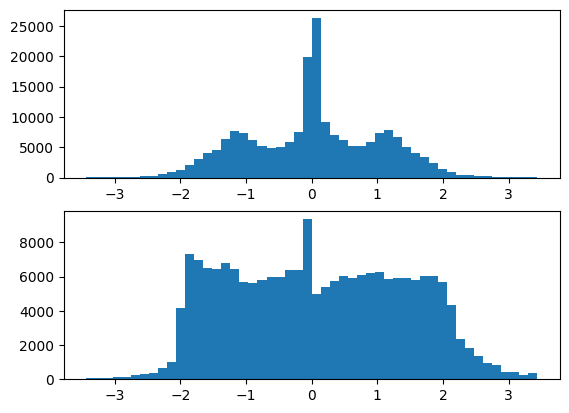

In [7]:
datestr = "%d-%m-%y_%H-%M" # all date inputs must follow this format
timestamp = datetime.now().strftime(datestr)
run_name = f"run_{timestamp[-5:]}_A{1}"
group_name = timestamp[:8]

train_num = 160
test_num = 7

# saving/loading information
data_dict = {
  "path" : "/home/luke/chess",
  "loadpath" : "/python/datasets",
  "loadfolder" : "datasetv8",
  "loadname" : "data_torch",
  "savepath" : "/python/models",
  "savefolder" : f"{group_name}/{run_name}",
  "savename" : "network",
  "train_inds" : list(range(1, train_num + 1)),
  "test_inds" : list(range(train_num + 1, 
                           train_num + test_num + 1)),
  "sample_method" : "weighted",
  "load_log_level" : 1,
  "save_log_level" : 1,
}

# create the trainer object
trainer = Trainer(data_dict)
# trainer.norm_factors = [10, 0, 4]
trainer.batch_limit = None
trainer.params.use_combined_loss = False
trainer.params.use_sf_eval = True

# # load in the dataset distribution data
# [sf_bin_counts, my_raw_bin_counts, my_sum_bin_counts] = trainer.dataloader.load("distribution", suffix_numbering=False)

batch_size = 64
total_batches = 0
device = "cpu"

# load the dataset in a series of slices (with randomised order)
train_load_indexes = trainer.data_dict['train_inds'][:]
random.shuffle(train_load_indexes)

train_load_indexes = [1]

num_batches = 200_000 // batch_size 
if trainer.batch_limit is not None: num_batches = trainer.batch_limit
samples = torch.zeros(batch_size * num_batches * len(train_load_indexes))
w_samples = torch.zeros(batch_size * num_batches * len(train_load_indexes))
sample_ind = 0
w_sample_ind = 0

for slice_num, j in enumerate(train_load_indexes):

  # load this segment of the dataset
  data_x, data_y, sf_evals, sq_evals = trainer.prepare_data(trainer.data_dict['loadname'], j, return_dataset=True)

  num_batches = len(data_x) // batch_size
  if num_batches == 0:
    raise RuntimeError("Trainer.train() found num_batches = 0")
  
  # useful for debugging and testing
  if trainer.batch_limit is not None:
    num_batches = trainer.batch_limit

  total_batches += num_batches
  rand_idx = torch.randperm(data_x.shape[0])
  avg_loss = 0

  t1 = time.time()

  trainer.weighted_sample_num_combined_bins = 20
  sampler = trainer.create_weighted_sampler(sf_evals)

  # iterate through each batch for this slice of the dataset
  for n in range(num_batches):

    # get a normal sample
    batch_x = data_x[rand_idx[n * batch_size : (n+1) * batch_size]]
    batch_y = data_y[rand_idx[n * batch_size : (n+1) * batch_size]]

    samples[sample_ind : sample_ind + batch_size] = batch_y
    sample_ind += batch_size

    # now get a weighted sample
    # w_x = data_x[w_sample_indicies[n * batch_size : (n+1) * batch_size]]
    # w_y = data_y[w_sample_indicies[n * batch_size : (n+1) * batch_size]]

    w_sample_indicies = list(sampler)
    w_x = data_x[w_sample_indicies]
    w_y = data_y[w_sample_indicies]

    w_samples[w_sample_ind : w_sample_ind + batch_size] = w_y
    w_sample_ind += batch_size

    # # go to device (small memory footprint, slightly slower)
    # batch_x = batch_x.to(device)
    # batch_y = batch_y.to(device)

print(f"The number of samples was {sample_ind}")

fig, axs = plt.subplots(2, 1)
axs[0].hist(samples.detach().numpy(), bins=50)
axs[1].hist(w_samples.detach().numpy(), bins=50)
plt.show()

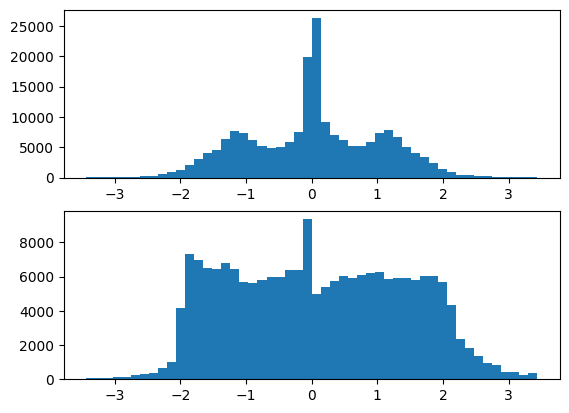

In [8]:
fig, axs = plt.subplots(2, 1)
axs[0].hist(samples.detach().numpy(), bins=50)
axs[1].hist(w_samples.detach().numpy(), bins=50)
plt.show()

In [9]:
load_kaggle = False
convert_kaggle = False
save_kaggle = False
new_kaggle_set = False

if load_kaggle:

  datapath = "/home/luke/chess/python/gamedata/kaggle"
  file_name = "chessData.csv"

  df = pd.read_csv(datapath + "/" + file_name)

if convert_kaggle:

  mate_value = 15 * 100
  positions = []
  print(f"The number of positions is {len(df['FEN'])}")

  # add all of the positions into the dataset
  for i in range(len(df["FEN"])):

    if i % 100_000 == 0: print(i / 1_000_000, end=" ")
    if i % 1_000_000 == 0: print()

    eval = df["Evaluation"][i]
    if eval.startswith("#+"):
      eval = mate_value
    elif eval.startswith("#-"):
      eval = -mate_value

    eval = int(eval)

    new_pos = Position(df["FEN"][i], eval, None)
    positions.append(new_pos)

if save_kaggle:

  tempsaver = ModelSaver(datapath)
  tempsaver.save("positions", positions)

if new_kaggle_set:

  dataset_name = "dataset_kaggle_2"
  file_name = "data"
  max_files = None          # maximum number of files to generate, default=None
  num_per = 200_000         # number of lines per saved file
  prevent_duplicates = True # prevent duplicates across the entire set, not just in each slice
  log_level = 1             # log level during the dataset generation (0=bare minimum, 1=normal)

  datasaver = ModelSaver("/home/luke/chess/python/datasets/", log_level=log_level)
  datasaver.new_folder(dataset_name)

  dataset = EvalDataset("", "", auto_load=False, log_level=log_level)
  
  # ensure key settings are correct
  dataset.use_all_moves = False
  dataset.use_eval_normalisation = False
  dataset.save_sq_eval = True

  # add in the kaggle positions
  dataset.positions = positions

  # remove any duplicates and mate positions
  num_duplicates = dataset.check_duplicates(remove=True)
  num_mates = dataset.check_mate_positions(remove=True)
  # dataset.to_torch() # old, convert ALL to torch

  # now randomise a selection of the indexes
  num_boards = dataset.count_all_positions()
  indexes = list(range(num_boards))
  random.shuffle(indexes)

  num_files = num_boards // num_per
  ind = 0

  if max_files is not None:
    if num_files > max_files:
      print(f"The number of files is limited from {num_files} to {max_files}")
      num_files = max_files

  print("num_files is", num_files)
  print("num_boards is", num_boards)
  
  for n in range(num_files):

    # random selection of indexes for the current file
    these_indexes = indexes[n * num_per : (n + 1) * num_per]
    
    # convert only the selected indexes to torch
    dataset.to_torch(indexes_only=these_indexes)

    # save the converted tensors
    datasaver.save(file_name + "_torch", [dataset.boards, dataset.evals, dataset.square_evals])

In [10]:
characterise_dataset = False

if characterise_dataset:

  dataset_name = "datasetv7"
  file_name = "data_torch"
  total_index = 141         # largest index number of gamedata/samples file
  log_level = 0             # log level during the dataset generation (0=bare minimum, 1=normal)
  clip_checkmate = 15       # clip largest eval to this value (checkmate essentially)

  dataloader = ModelSaver(f"/home/luke/chess/python/datasets/", log_level=log_level)
  dataloader.enter_folder(dataset_name)

  indexes = list(range(1, total_index + 1))

  sf_file_means = []
  sf_file_var = []
  sf_file_max = []
  my_file_means = []
  my_file_var = []
  my_file_max = []
  both_file_means = []
  both_file_var = []
  both_file_max = []

  for i in indexes:

    loaded_data = dataloader.load(file_name, id=i)
    data_sf = loaded_data[1]
    data_my = loaded_data[2]
    data_both = torch.cat((loaded_data[1].unsqueeze(1), loaded_data[2]), dim=1)

    # clip large values
    data_sf = torch.clip(data_sf, -clip_checkmate, clip_checkmate)
    data_my = torch.clip(data_my, -clip_checkmate, clip_checkmate)
    data_both = torch.clip(data_both, -clip_checkmate, clip_checkmate)

    sf_file_means.append(torch.mean(data_sf).item())
    sf_file_var.append(torch.var(data_sf).item())
    sf_file_max.append(torch.max(torch.abs(data_sf)).item())
    my_file_means.append(torch.mean(data_my).item())
    my_file_var.append(torch.var(data_my).item())
    my_file_max.append(torch.max(torch.abs(data_my)).item())
    both_file_means.append(torch.mean(data_both).item())
    both_file_var.append(torch.var(data_both).item())
    both_file_max.append(torch.max(torch.abs(data_both)).item())

  my_means = np.array(my_file_means)
  my_overall_mean = np.mean(my_means)
  my_overal_std = np.sqrt(np.mean(my_file_var) + np.mean(np.power(my_means - my_overall_mean, 2)))
  my_max = np.max(my_file_max)

  sf_means = np.array(sf_file_means)
  sf_overall_mean = np.mean(sf_means)
  sf_overal_std = np.sqrt(np.mean(sf_file_var) + np.mean(np.power(sf_means - sf_overall_mean, 2)))
  sf_max = np.max(sf_file_max)

  both_means = np.array(both_file_means)
  both_overall_mean = np.mean(both_means)
  both_overal_std = np.sqrt(np.mean(both_file_var) + np.mean(np.power(both_means - both_overall_mean, 2)))
  both_max = np.max(both_file_max)

  print(f"Stockfish (mean, std, max) = ({sf_overall_mean:.3f}, {sf_overal_std:.3f}, {sf_max:.3f})")
  print(f"My evals (mean, std, max) = ({my_overall_mean:.3f}, {my_overal_std:.3f}, {my_max:.3f})")
  print(f"Both (mean, std, max) = ({both_overall_mean:.3f}, {both_overal_std:.3f}, {both_max:.3f})")  

In [11]:
shuffle_dataset = False

if shuffle_dataset:

  old_dataset_name = "dataset_v5_and_kaggle"
  new_datase_name = "datasetv6"
  dataset_ind = 159

  dataloader = ModelSaver(f"/home/luke/chess/python/datasets/{dataset_name}")
  boards, evals, sq_evals = dataloader.load("data_torch", id=dataset_ind)

In [12]:
def normalise_data(data, factors, clip=None):
  """
  Normalise data based on [max, mean, std]
  """
  max, mean, std = factors
  d = ((data - mean) / std) / max
  if clip is not None:
    d = torch.clip(d, min=-clip, max=clip)
  return d

examine = False

if examine:

  factors = [23.927, -0.240, 0.355]
  factors = [3, -0.240, 0.355]
  norm_evals = normalise_data(dataset.evals, factors, clip=1)

  fig, axs = plt.subplots(1, 1)
  axs.hist(norm_evals.numpy(), bins=50)
  plt.show()

  print(torch.max(dataset.evals))
  print(torch.min(dataset.evals))

In [13]:
rexamine = False

if rexamine:

  # load all of the dataset files to examine the data distribution
  max_values = []
  mean_values = []
  std_values = []
  for i in range(1, 11):
    this_data = datasaver.load("datasetv1", id=i)
    this_data.normalise_evaluations()
    max_values.append(this_data.norm_factor[0])
    mean_values.append(this_data.norm_factor[1])
    std_values.append(this_data.norm_factor[2])

  true_max = np.max(max_values)
  avg_mean = np.mean(mean_values)
  avg_std = np.mean(std_values)

  print(f"True max = {true_max:.3f}, true mean = {avg_mean:.3f}, average std = {avg_std:.3f}")

  norm_factors = [true_max, avg_mean, avg_std]

else:
  # True max = 23.927, true mean = -0.240, average std = 0.355
  norm_factors = [23.927, -0.240, 0.355]


In [14]:
# def normalise_data(data, factors):
#   """
#   Normalise data based on [max, mean, std]
#   """
#   max, mean, std = factors
#   return ((data - mean) / std) / max

# def denormalise_data(data, factors):
#   """
#   Undo normalisation based on [max, mean, std]
#   """
#   max, mean, std = factors
#   return (data * max * std) + mean

def normalise_data(data, factors):
  """
  Normalise data based on [max, mean, std]
  """

  # max, mean, std = self.norm_factors[:3]

  clip, mean, std = factors
  data = torch.clip(data, min=-clip, max=clip)
  data = data - mean
  data = data / std
  return data
  data = ((data - mean) / std)
  return data

def denormalise_data(data, factors):
  """
  Undo normalisation based on [max, mean, std]
  """
  clip, mean, std = factors
  data = data * std
  data = data + (mean / std)
  return data
  return (data * std) + mean

def train_procedure(net, dataname, dataloader, data_inds, norm_factors,
                    epochs=1, lr=1e-7, device="cuda", batch_size=64,
                    loss_style="MSE"):
  """
  Perform a training epoch for a given network based on data inputs
  data_x, and correct outputs data_y
  """

  # move onto the specified device
  net.board_cnn.to(device)

  # put the model in training mode
  net.board_cnn.train()

  if loss_style.lower() == "mse":
    lossfcn = nn.MSELoss()
  elif loss_style.lower() == "l1":
    lossfcn = nn.L1Loss()
  elif loss_style.lower() == "huber":
    lossfcn = nn.HuberLoss()
  else:
    raise RuntimeError(f"train_procedure() error: loss_style = {loss_style} not recognised")

  optim = torch.optim.Adam(net.board_cnn.parameters(), lr=lr)
  
  # each epoch, cover the entire training dataset
  for i in range(epochs):

    print(f"Starting epoch {i + 1}.")
    total_batches = 0
    epoch_loss = 0

    # load the dataset in a series of slices
    for slice_num, j in enumerate(data_inds):

      # load this segment of the dataset
      dataset = dataloader.load(dataname, id=j)
      data_x = dataset.boards
      data_y = dataset.evals

      # import sys
      # print("The size in bytes of data_x", sys.getsizeof(data_x.storage()))
      # print("The size in bytes of data_y", sys.getsizeof(data_y.storage()))

      # normalise y labels
      data_y = normalise_data(data_y, norm_factors)

      num_batches = len(data_x) // batch_size
      total_batches += num_batches
      rand_idx = torch.randperm(data_x.shape[0])
      avg_loss = 0

      print(f"Starting slice {slice_num + 1} / {len(data_inds)}. There will be {num_batches} batches. ", end="", flush=True)

      # iterate through each batch for this slice of the dataset
      for n in range(num_batches):

        batch_x = data_x[rand_idx[n * batch_size : (n+1) * batch_size]]
        batch_y = data_y[rand_idx[n * batch_size : (n+1) * batch_size]]

        # go to cuda
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # use the model for a prediction and calculate loss
        net_y = net.board_cnn(batch_x)
        loss = lossfcn(net_y.squeeze(1), batch_y)

        # backpropagate
        loss.backward()
        optim.step()
        optim.zero_grad()

        avg_loss += loss.item()

        # if n % 500 == 0:
        #   print(f"Loss is {(avg_loss / (n + 1)) * 1000:.3f}, epoch {i + 1}, batch {n + 1} / {num_batches}")

      # this dataset slice is finished
      epoch_loss += avg_loss
      avg_loss = avg_loss / num_batches
      avg_loss = avg_loss ** 0.5 * norm_factors[0] * norm_factors[2] # try to scale to original units
      print(f"Loss is {avg_loss:.3f}, during epoch {i + 1}, slice {slice_num + 1} / {len(data_inds)}", flush=True)
  
    # this epoch is finished
    epoch_loss = epoch_loss / total_batches
    epoch_loss = epoch_loss ** 0.5 * norm_factors[0] * norm_factors[2] # try to scale to original units
    print(f"Epoch {i + 1} has finished after {total_batches} batches. Overall average loss = {epoch_loss:.3f}", flush=True)

  # finally, return the network that we have trained
  return net

do_train_procedure = False

if do_train_procedure:

  net = ChessNet(19)

  device = "cuda"
  epochs = 10
  data_inds = list(range(1, 11))
  lr = 1e-7

  trained_net = train_procedure(
    net=net,
    dataname="datasetv1",
    dataloader=ModelSaver("/home/luke/chess/python/datasets/", log_level=1),
    data_inds=list(range(1, 11)),
    norm_factors=[23.927, -0.240, 0.355], # [max, mean, std]
    epochs=epochs,
    lr=lr,
    device=device    
  )

In [20]:
def torch_to_board_vec(tensor):
  """
  Convert a torch board vector into a cpp board vector
  """

  boardvec = bf.BoardVectors()

  boardvec.wP = list(tensor[0].reshape(64))
  boardvec.wN = list(tensor[1].reshape(64))
  boardvec.wB = list(tensor[2].reshape(64))
  boardvec.wR = list(tensor[3].reshape(64))
  boardvec.wQ = list(tensor[4].reshape(64))
  boardvec.wK = list(tensor[5].reshape(64))
  boardvec.bP = list(tensor[6].reshape(64))
  boardvec.bN = list(tensor[7].reshape(64))
  boardvec.bB = list(tensor[8].reshape(64))
  boardvec.bR = list(tensor[9].reshape(64))
  boardvec.bQ = list(tensor[10].reshape(64))
  boardvec.bK = list(tensor[11].reshape(64))
  boardvec.wKS = list(tensor[12].reshape(64))
  boardvec.wQS = list(tensor[13].reshape(64))
  boardvec.bKS = list(tensor[14].reshape(64))
  boardvec.bQS = list(tensor[15].reshape(64))
  boardvec.colour = list(tensor[16].reshape(64))

  return boardvec

loadexisting = True

if loadexisting:

  if False:
    modelloader = ModelSaver("/home/luke/chess/python/models/")
    trained_net = modelloader.load("chessnet_model", id=None)
  else:
    group = "26-11-24"
    run = "run_12-38_A2"
    modelloader = ModelSaver(f"/home/luke/chess/python/models/{group}/{run}")
    trained_net = modelloader.load("network", id=None)
  
  dataset_name = "datasetv9"
  dataset_ind = 180
  dataloader = ModelSaver(f"/home/luke/chess/python/datasets/{dataset_name}")
  boards, evals, sq_evals = dataloader.load("data_torch", id=dataset_ind)

  device = "cuda"
  trained_net.to(device)
  boards = boards.to(device)
  evals = evals.to(device)
  sq_evals = sq_evals.to(device)

  trained_net.eval()

rand = False
inds = list(range(len(evals)))
if rand:
  random.shuffle(inds)

factors = [7, 0, 2.159]
factors = [10, 0, 4]
factors = [15, 0, 4.369]

my_pred_vec = []
sf_pred_vec = []
my_diff_vec = []
sf_diff_vec = []
sf_vec = []
my_vec = []

avg_diff_sf = 0
avg_diff_my = 0
n = 2000
inds = inds[:n]
for i in inds:

  # board piece rating comparison
  net_eval = (trained_net(boards[i].unsqueeze(dim=0))).to("cpu").squeeze(0)
  net_eval = denormalise_data(net_eval, factors=factors)

  this_board_vec = boards[i].to("cpu")
  this_sf_eval = evals[i].to("cpu")
  this_sq_evals = sq_evals[i].to("cpu")
  this_my_eval = torch.sum(this_sq_evals).item()

  # board_vec = bf.FEN_to_board_vectors_with_eval(dataset.positions[i].fen_string)
  # board_vec = torch.tensor(board_vec.sq_evals, dtype=torch.float) * 1e-3

  if len(net_eval) == 65:
    net_sf = net_eval[0].item()
    net_my = torch.sum(net_eval[1:])
    sf_diff = this_sf_eval - net_sf
    my_diff = this_my_eval - net_my
    net_eval = net_eval[1:]

  elif len(net_eval) == 64: 
    net_sf = torch.sum(net_eval).detach()
    net_my = torch.sum(net_eval).detach()
    sf_diff = this_sf_eval - net_my
    my_diff = this_my_eval - net_my

  else: raise RuntimeError(f"len(net_eval) = {len(net_eval)}")

  net_print = torch.zeros((8, 8))
  true_print = torch.zeros((8, 8))
  
  torch.round(net_eval.reshape(8,8).detach(), decimals=2, out=net_print)
  torch.round(this_sq_evals.reshape(8,8).detach(), decimals=2, out=true_print)

  my_pred_vec.append(net_my.item())
  my_diff_vec.append(my_diff.detach().item())
  sf_pred_vec.append(net_sf)
  sf_diff_vec.append(sf_diff.detach().item())
  sf_vec.append(this_sf_eval.detach().item())
  my_vec.append(this_my_eval)

  avg_diff_sf += abs(sf_diff)
  avg_diff_my += abs(my_diff)
  
  if n <= 50:
    print(f"Case {i + 1} / {n}.", end=" ")
    if n < 6:
      print("Board:")
      bf.print_board_vectors(torch_to_board_vec(this_board_vec))
      # bf.print_FEN_board(dataset.positions[i].fen_string)
      print("Net eval was\n", net_print)
      print("Ground truth was\n", true_print)
    print(f"Stockfish: true eval = {this_sf_eval:.3f}, net eval = {net_sf:.3f}, difference = {this_sf_eval - net_sf:.3f}")

diff_sf = np.array(sf_diff_vec)
mean_sf_diff = np.mean(np.abs(diff_sf))
std_sf_diff = np.std(diff_sf)

diff_my = np.array(my_diff_vec)
mean_my_diff = np.mean(np.abs(diff_my))
std_my_diff = np.std(diff_my)

sf_vec = np.array(sf_vec)

print(f"The average difference from {n} samples is u={mean_my_diff:.3f} s={std_my_diff:.3f}, stockfish average difference is u={mean_sf_diff:.3f} s={std_sf_diff:.3f}")

fig, axs = plt.subplots(3, 2)
# axs[0].hist(evals.detach().to("cpu").numpy(), bins=40, range=(-10, 10))

norm = normalise_data(torch.tensor(sf_vec), factors=factors)
norm = norm.detach().numpy()

axs[0][0].hist(sf_vec, bins=40, range=(-10, 10))
axs[1][0].hist(sf_pred_vec, bins=40, range=(-10, 10))
axs[2][0].hist(diff_sf, bins=40, range=(-10, 10))
axs[0][1].hist(norm, bins=40)
axs[1][1].hist(my_pred_vec, bins=40, range=(-10, 10))
axs[2][1].hist(diff_my, bins=40, range=(-10, 10))
axs[0][0].set_title("True stockfish evaluations")
axs[1][0].set_title("Stockfish predictions")
axs[2][0].set_title("Stockfish evaluation difference")
axs[0][1].set_title("True my evaluations")
axs[1][1].set_title("My evaluation predictions")
axs[2][1].set_title("My evaluation function difference")
fig.tight_layout()
plt.show()

Loading file /home/luke/chess/python/models/26-11-24/run_12-38_A1/network_010.lz4 with pickle ... finished
Loading file /home/luke/chess/python/datasets/datasetv9/data_torch_180.lz4 with pickle ... finished


RuntimeError: len(net_eval) = 1

In [16]:
time_net = True

if time_net:

  timedevice = "cpu"
  trained_net.board_cnn.eval()
  trained_net.board_cnn.to(timedevice)
  static_board = boards[0].to(timedevice).unsqueeze(dim=0)
  num = 1000
  j = 0

  t1 = time.process_time()
  for i in range(num):
    trained_net.board_cnn(static_board)
    j += 1
    if j >= len(boards):
      j = 0
  t2 = time.process_time()

  print(f"Network: Total time {t2 - t1:.1f}s, so {((t2 - t1) / num) * 1e3:.3f} ms per evaluation (approx {1 / (30 * (t2 - t1) / num):.1f} boards per s)")

  t1 = time.process_time()
  for i in range(num):
    bf.generate_moves_FEN(dataset.positions[j].fen_string)
    j += 1
    if j >= len(dataset.boards):
      j = 0
  t2 = time.process_time()

  print(f"Handcrafted: Total time {t2 - t1:.1f}s, so {((t2 - t1) / num) * 1e3:.3f} ms per board (approx {1 / ((t2 - t1) / num):.1f} boards per s)")

Network: Total time 0.3s, so 0.265 ms per evaluation (approx 125.9 boards per s)
Handcrafted: Total time 0.5s, so 0.524 ms per board (approx 1908.4 boards per s)


In [17]:
# trace model, but move to the cpu before saving
trained_net.to("cpu")
example = boards[0].unsqueeze(dim=0).to("cpu")
traced_net = torch.jit.trace(trained_net, example)

traced_net.save("/home/luke/chess/python/models/traced_model.pt")